## Task/End goal
> Be able to classify CODM users as satsfied/dissatisfied based on their review

In [88]:
import re
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
data = pd.read_csv("Call Of Duty.csv")

In [90]:
data.head()

,reviews,ratings
0,I've been playing for years now and it's been ...,4
1,An annoying experience all round. Ever since t...,1
2,"I love the game though. It's close to real, bu...",3
3,I've been playing for years now and it's been ...,4
4,An annoying experience all round. Ever since t...,1


## EDA/Feature engineering

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3882 non-null   object
 1   ratings  3882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [92]:
data.isna().sum()

reviews    0
ratings    0
dtype: int64

In [93]:
data.describe()

,ratings
count,3882.000000
mean,3.202473
std,1.572016
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,5.000000


In [94]:
# Classifying reviews as binary (Satisfied =1, dissatisfied = 0) and creation of new column
# Satisfied user == 3+ stars rating, dissatisfied == 2< stars rating 
data["satisfied"] = data["ratings"].apply(lambda x: 1 if x >=3 else 0)

In [95]:
data.head()

,reviews,ratings,satisfied
0,I've been playing for years now and it's been ...,4,1
1,An annoying experience all round. Ever since t...,1,0
2,"I love the game though. It's close to real, bu...",3,1
3,I've been playing for years now and it's been ...,4,1
4,An annoying experience all round. Ever since t...,1,0


In [96]:
# users grouped by satisfaction status
reviews_by_satisfaction = data.groupby("satisfied")

# number of satisfied and unsatisfied users
reviews_by_satisfaction["satisfied"].count()

satisfied
0    1382
1    2500
Name: satisfied, dtype: int64

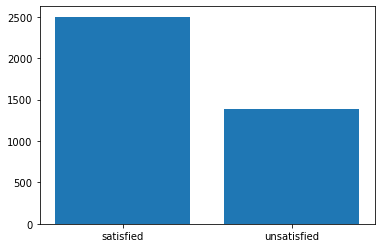

In [97]:
# Visualization of satisfide/unsatisfied ratings count

satisfied = reviews_by_satisfaction.get_group(1)
satisfied = satisfied["ratings"].count()

unsatisfied = reviews_by_satisfaction.get_group(0)
unsatisfied = unsatisfied["ratings"].count()

plt.bar(["satisfied", "unsatisfied"], [satisfied, unsatisfied])
plt.show()

In [98]:
# Making all texts lowercase.
data["reviews"] = data["reviews"].apply(lambda x: x.lower())

# Removing numbers.
data["reviews"] = data["reviews"].apply(lambda x: re.sub(r'[0-9]+', "", x))

# Removing white space
data["reviews"] = data["reviews"].apply(lambda x: x.strip())

In [99]:
# Removing special characters.
# Some characters replced here are words used in reviews that made no meaning.
# iinstead of adding them to stopwords, they were removed here after being noticed along the line.
data["reviews"] = data["reviews"].apply(lambda x: x.replace(",", " ").replace(":", " ").replace(".", " ")
.replace("'", " ").replace("%", " ").replace(";", " ").replace("/", " ").replace('"', " ").replace("(", " ")
.replace(")", " ").replace("!", " ").replace("+", " ").replace("@", " ").replace("*", " ").replace("$", " ")
.replace("&", " ").replace("-", " ").replace("?", " ").replace("#", " ").replace("  ", " ").replace("£", " ")
.replace("_", " ").replace(" 🏽", " ").replace("\n", " ").replace("`", " ").replace("aa", "").replace("aaaaawwwwwsssoom", "")
.replace("aaa", ""))

# replacing emojis with text.
# These emojis are emojis that I found to be most common to CODM reviews.
data["reviews"] = data["reviews"].apply(lambda x: x.replace("😎", " cool_face ").replace("😴", " sleepy_face ")
.replace("👍", " thumbs_up ").replace("👎", " thumbs_down ").replace("👌", " nice ").replace("🖕", " middle_finger ")
.replace("😆", " excitement ").replace("😅", " awkward ").replace("⭐", " star ").replace("💯", " approval ")
.replace("🤘", " cool ").replace("😉", " wink_face ").replace("❤", " love ").replace("😁", " cheer ")
.replace("🎮", " controller ").replace("🌟", " glowing_star ").replace("😂", " laughing_face ")
.replace("🙃", " upside-down-face").replace("🤭", " surprise_face ").replace("😝", " playful_face ")
.replace("😩", " exhaustion_face ").replace("❤️", " love ").replace("😍", " adoration ").replace("🙏", " pray ")
.replace("🙄", " rolling_eyes ").replace("😭", " crying_face ").replace("😑", " neutral_face ").replace("😏", " smirk_face ")
.replace("😡", " angry_face ").replace("😪", " sleepy_face ").replace("😓", " frustration_face ").replace("😀", " cheer_face ")
.replace("😒", " unasumed_face ").replace(" 🏝", " desert_island ").replace("🥴", " woozy_face ").replace("😊", " smiling_face ")
.replace("🥰", " feeling_loved ").replace("😃", " cheer_face ").replace("🤬",  " being_vulgar ").replace("🥺", " pleeding_face ")
.replace("🤣", " floor_laughing ").replace("😔", " dissapointed_face ").replace("🤞", " for_luck ").replace("🤡", " clown_face ")
.replace("😤", " highly_annoyed ").replace("👿", " angry_face_with_horns ").replace("🙂", " weird_smile ").replace("😊", " happy ")
.replace("💪", " flexed_biceps ").replace("🤯", " mind_blown ").replace("📌", "pin").replace("😋", " tongue_out ")
.replace("🤔", " thinking_emoji ").replace("😥", " sad_but_relieved_face ").replace("😞", " disappointed_face ")
.replace("😕", " confused_face ").replace("💖", " sparkling_heart ").replace("💋", " kiss ").replace("👹", " devil_face ")
.replace("👏", " clap_emoji ").replace("🤟", " i_love_you ").replace("🤷", " giving_up ").replace("🥵",  "hot_face ")
.replace("😌", " relieved_face ").replace("😳", " flushed_face ").replace("🔥", " fire_emoji ").replace("🛑", " stop_sign ")
.replace("💕", " two_hearts ").replace("😣", " persevering_face ").replace("☹️", " sad_face ").replace("🙌", " raising_hands ")
.replace("😛", " tongue_out ").replace("🤧", " sneezing_face ").replace("😠", " angry_face ").replace("😕",  "confused_face ")
.replace("🚫", " stop_sign ").replace("🧢", " cap ").replace("❗", " exclamation ").replace("🤩", " star_eyes ").replace("😐", " bored_face ")
.replace("🤑", " money_eyes ").replace("⚠️", " caution_sign ").replace("🌦️", " rainy_weather ").replace("🔆", " high_brightness ")
.replace("💙", " blue_heart ").replace("✌️", " peace_sign ").replace("💀", " skull").replace("😜", " wink ").replace("🤗", " hugging_face ")
.replace("💣", " bomb ").replace("💝", " wrapped_heart ").replace("♥️", " love ").replace("😢", " sad_face ").replace("📱", " phone ")
.replace("🥳", " celebrate ").replace("💞", " rolling_hearts ").replace("👊", " fist ").replace("💰", " money_bag ").replace("💔", " heart_break ")
.replace("✊🏾", " black_fist_up ").replace("😬", " discomfort ").replace("🤦‍♂️", " face_palm ").replace("🤪", " goofy_face ")
.replace("📢", " hand_horn ").replace("💥", " bang ").replace("🤍", " white_heart ").replace("🧡", " orange_heart ").replace("😘", " kiss ")
.replace("☺️", " smiling_face ").replace("🎯", " on_target ").replace("💜", " purple_heart ").replace("😫", " weary_face ")
.replace("🎉", " celebration ").replace("👋", " hand_wave ").replace("🤙", " call_me_hand ").replace("🤢", " feeling_sick ")
.replace("😟", " sad_face "))

In [100]:
data.head()

,reviews,ratings,satisfied
0,i ve been playing for years now and it s been ...,4,1
1,an annoying experience all round ever since th...,1,0
2,i love the game though it s close to real but ...,3,1
3,i ve been playing for years now and it s been ...,4,1
4,an annoying experience all round ever since th...,1,0


In [101]:
# word tokenization
text_tokens = data["reviews"].apply(lambda review : word_tokenize(review, language="english"))

# removal of stop words, words less than 2 characters long, word stemming and creation of new column
stemmer = PorterStemmer()
stop = stopwords.words('english')
data["final_word_corpus"] = data['reviews'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.lower().split() if len(word) >2 and word not in (stop)]))

In [102]:
data.head()

,reviews,ratings,satisfied,final_word_corpus
0,i ve been playing for years now and it s been ...,4,1,play year quit addict develop plss fix issu se...
1,an annoying experience all round ever since th...,1,0,annoy experi round ever sinc updat season wild...
2,i love the game though it s close to real but ...,3,1,love game though close real greatest problem c...
3,i ve been playing for years now and it s been ...,4,1,play year quit addict develop plss fix issu se...
4,an annoying experience all round ever since th...,1,0,annoy experi round ever sinc updat season wild...


In [103]:
# extracting needed columns from entire DataFrame.
corpus_satisfaction = data[["final_word_corpus", "satisfied"]]
# corpus_satisfaction.to_csv("reviews_corpus.csv", index=False)
corpus_satisfaction.head()

,final_word_corpus,satisfied
0,play year quit addict develop plss fix issu se...,1
1,annoy experi round ever sinc updat season wild...,0
2,love game though close real greatest problem c...,1
3,play year quit addict develop plss fix issu se...,1
4,annoy experi round ever sinc updat season wild...,0


In [104]:
def create_corp_dict(dataframe):
    """Function creates dictionary containing satisfied and unsatisfied user word tokens"""

    # Grouping 'final_word_corpus' by satisfaction
    reviews_by_satisfaction = corpus_satisfaction.groupby("satisfied")
    satisfied = reviews_by_satisfaction.get_group(1) # satisfied users word tokens
    unsatisfied = reviews_by_satisfaction.get_group(0) # unsatisfied users word tokens


    satisfied_corpos = [] # 2D array of satisfied reviews words
    unsatisfied_corpos = [] # 2D array of ussatisfied reviews words


    # extracting every word in satisfied users review
    for word in satisfied["final_word_corpus"]:
        satisfied_corpos.append(word.split())
    final_satisfied_corpos = [word for words in satisfied_corpos for word in words] # 1D array of satisfied reviews words
    final_satisfied_corpos_string = " ".join(final_satisfied_corpos) # String containing all satisfied user tokens

    # extracting every word in unsatisfied users review
    for word in unsatisfied["final_word_corpus"]:
        unsatisfied_corpos.append(word.split())
    final_unsatisfied_corpos = [word for words in unsatisfied_corpos for word in words] # 1D array of unsatisfied reviews words
    final_unsatisfied_corpos_string = " ".join(final_unsatisfied_corpos) # String containing all unsatisfied user tokens

    # Adding words from satisfied and unsatisfied reviews into dictionary for frequency count
    satisfied_unsatisfied_words ={
        "satisfied": final_satisfied_corpos_string,
        "unsatisfied": final_unsatisfied_corpos_string
    }
    return satisfied_unsatisfied_words

satisfied_unsatisfied_words = create_corp_dict(corpus_satisfaction)

In [105]:
# DataFrame of all word lemmas used in satisfied and unsatisfied reviews 
concatenated_reviews = pd.DataFrame(satisfied_unsatisfied_words, index=["review_tokens"])
concatenated_reviews = concatenated_reviews.T # transposed dataframe
concatenated_reviews

,review_tokens
satisfied,play year quit addict develop plss fix issu se...
unsatisfied,annoy experi round ever sinc updat season wild...


In [106]:
# Calculating Document term matrix and converting to DataFrame.
cv = CountVectorizer(stop_words="english")
concatenated_reviews_cv = cv.fit_transform(concatenated_reviews["review_tokens"])
document_term_matrix = pd.DataFrame(concatenated_reviews_cv.toarray(),columns =cv.get_feature_names_out(), index=["satisfied", "unsatisfied"])

# Transposing dataframe for easy manipulation across columns
document_term_matrix = document_term_matrix.T

In [107]:
# Sorting terms by frequency in descending order
AMOUNT = 200 # Number of top terms to retreive.

top_terms_dict = {}
for col in document_term_matrix.columns:
    top_terms = document_term_matrix[col].sort_values(ascending=False).head(AMOUNT)
    top_terms_dict[col] = top_terms.index

# Dataframe of top words
top_terms_df= pd.DataFrame(top_terms_dict)
print("Data Frame containing top words for each reviews type")
top_terms_df.head(10)

Data Frame containing top words for each reviews type


,satisfied,unsatisfied
0,game,game
1,play,play
2,like,updat
3,good,time
4,updat,fix
5,love,like
6,great,download
7,graphic,use
8,time,match
9,mobil,pleas


> The above dataframe suggests that;
- both satisfiied and unsatisfied user reviews share most common words. Hence, those words need to be removed as the 
  don't add much value to the difference between both review types

In [108]:
# Comparing top n terms from satisfied and unsatisfied reviews
# to compare terms and produce new stop words.

# Extracting top n terms to list
satisfied_top_n = top_terms_dict.get("satisfied")
unsatisfied_top_n = top_terms_dict.get("unsatisfied")

# Checking for presence of term from satisfied_top_n in unsatisfied_top_n
custom_stop_words = [term for term in satisfied_top_n if term in unsatisfied_top_n]
print("There are %d most common terms in top %d satisfied and unsatisfied user reviews" %(len(custom_stop_words), AMOUNT))

There are 151 most common terms in top 200 satisfied and unsatisfied user reviews


In [109]:
# Removing custom stop words from already lemmatized dataframe
# custom_stop_words
data["final_word_corpus"] = data["final_word_corpus"].apply(lambda x: ' '.join(word for word in x.split() if word not in (custom_stop_words)))
corpus_satisfaction_2 = data[["final_word_corpus", "satisfied"]]
corpus_satisfaction_2.head() # DF containing lemmatized reviews with 2 rounds of dropped stopwords.

,final_word_corpus,satisfied
0,addict plss see far distanc vulner surpris att...,1
1,round ever wild dog unabl without crack intere...,0
2,though greatest consist upgrad larg taken redu...,1
3,addict plss see far distanc vulner surpris att...,1
4,round ever wild dog unabl without crack intere...,0


In [110]:
# Re-grouping 'corpus_satisfaction_2' by satisfaction
reviews_by_satisfaction = corpus_satisfaction_2.groupby("satisfied")
satisfied = reviews_by_satisfaction.get_group(1) # satisfied users word tokens
unsatisfied = reviews_by_satisfaction.get_group(0) # unsatisfied users word tokens

satisfied_corpos_2 = [] # 2D array of satisfied reviews words
unsatisfied_corpos_2 = [] # 2D array of ussatisfied reviews words


# Re-extracting every word in satisfied users review
for word in satisfied["final_word_corpus"]:
    satisfied_corpos_2.append(word.split())
final_satisfied_corpos = [word for words in satisfied_corpos_2 for word in words] # 1D array of satisfied reviews words
final_satisfied_corpos_string_2 = " ".join(final_satisfied_corpos) # String containing all satisfied user tokens

# Re-extracting every word in satisfied users review
for word in unsatisfied["final_word_corpus"]:
    unsatisfied_corpos_2.append(word.split())
final_unsatisfied_corpos = [word for words in unsatisfied_corpos_2 for word in words] # 1D array of satisfied reviews words
final_unsatisfied_corpos_string_2 = " ".join(final_unsatisfied_corpos) # String containing all satisfied user tokens

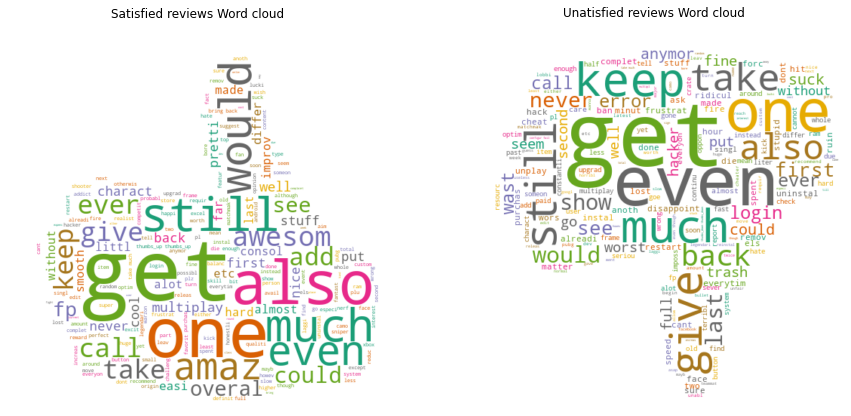

In [114]:
mask_up = np.array(Image.open("thumbs_up.png"))
mask_down = np.array(Image.open("thumbs_down.png"))

# Plotting word clouds.
wc_up = WordCloud(stopwords=stop, background_color="white", colormap='Dark2', max_font_size=120, random_state=30, mask=mask_up)
wc_down = WordCloud(stopwords=stop, background_color="white", colormap='Dark2', max_font_size=120, random_state=30, mask=mask_down)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Satisfied reviews Word cloud")
satisfied_wc = wc_up.generate(final_satisfied_corpos_string_2) # Satisfied reviews word cloud
plt.imshow(satisfied_wc, interpolation="bilinear")
plt.axis('off')

plt.subplot(1,2,2)
unsatisfied_wc = wc_down.generate(final_unsatisfied_corpos_string_2) # Satisfied reviews word cloud
plt.imshow(unsatisfied_wc, interpolation="bilinear")
plt.title("Unatisfied reviews Word cloud")
plt.axis('off')

plt.show()

> Findings;
- Both reviews use the word 'get' and 'one' a lot
- Positive reviews contain the words 'add, could, still, would' which suggest that they may be making suggestions
- Negative reviews contain the word 'login' which suggests that users encounter login issues
- Negative reviews contain the word 'hacker' which suggests that some users encounter hackers while playing
> I'm likely to gain more insight if I calculate bigrams and trigrams

# Model Training